# Mask Classification 

### Importing the libraries

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import random
import cv2
import matplotlib
matplotlib.use("Agg")



## Part 1 - Data Preprocessing

### Importing the dataset

In [ ]:
data = []
labels = []

imagePaths=[]
directory = ['/content/drive/My Drive/MaskDetector Dataset/No Mask/','/content/drive/My Drive/MaskDetector Dataset/With Mask/']
for dir in directory:
  for filename in os.listdir(dir):
    imagePaths.append(dir+filename)
# grab the image paths and randomly shuffle them
random.seed(42)
random.shuffle(imagePaths)

### Loading Images and labels

In [ ]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

### Encoding categorical data

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Splitting the dataset into the Training set and Test set

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

### Data Augementation 

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

##  Part 2 - Loading and Building the Model - MobileNet2

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

###  Compiling the Model

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

### Training 

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
43/43 [==============================] - 16s 369ms/step - loss: 0.4232 - accuracy: 0.8020 - val_loss: 0.1534 - val_accuracy: 0.9659
Epoch 2/20
43/43 [==============================] - 15s 352ms/step - loss: 0.1661 - accuracy: 0.9396 - val_loss: 0.0864 - val_accuracy: 0.9744
Epoch 3/20
43/43 [==============================] - 15s 351ms/step - loss: 0.1068 - accuracy: 0.9622 - val_loss: 0.0687 - val_accuracy: 0.9801
Epoch 4/20
43/43 [==============================] - 15s 352ms/step - loss: 0.0756 - accuracy: 0.9818 - val_loss: 0.0578 - val_accuracy: 0.9801
Epoch 5/20
43/43 [==============================] - 15s 352ms/step - loss: 0.0609 - accuracy: 0.9789 - val_loss: 0.0511 - val_accuracy: 0.9886
Epoch 6/20
43/43 [==============================] - 15s 354ms/step - loss: 0.0516 - accuracy: 0.9854 - val_loss: 0.0477 - val_accuracy: 0.9886
Epoch 7/20
43/43 [==============================] - 15s 358ms/step - loss: 0.0520 - accuracy: 0.9811 - val_loss: 0.0448 - val_accuracy: 0.9915

### Evaluating the Network

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

     No Mask       0.98      1.00      0.99       167
   With Mask       1.00      0.98      0.99       185

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352



In [ ]:
# Losses and Accuracy Graphs
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Part 3 -  Saving the model and labels for future

In [ ]:
import pickle

model.save('/content/drive/My Drive/MaskDetector Dataset/maskclassfier.model', save_format="h5")
f = open('/content/drive/My Drive/MaskDetector Dataset/labels_mask.pickle', "wb")
f.write(pickle.dumps(lb.classes_))
f.close()



## Part 4 - Detecting Faces and then Masked Faces

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
import pickle

### Loading the pretrained Face Detector Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
prototxtPath = '/content/drive/My Drive/face_detector/deploy.prototxt'
weightsPath = '/content/drive/My Drive/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(prototxtPath, weightsPath)

### Loading the Classifier model  and labels

In [ ]:
model = load_model('/content/drive/My Drive/MaskDetector Dataset/maskclassfier.model')
lb = pickle.loads(open('/content/drive/My Drive/MaskDetector Dataset/labels_mask.pickle', "rb").read())



### Loading and Preprocessing Testing Image

In [ ]:
image = cv2.imread('/content/drive/My Drive/example06.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

In [ ]:
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

In [ ]:
#Computing face detections
net.setInput(blob)
detections = net.forward()

In [ ]:
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        (withoutMask,mask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        print(label)

Mask: 98.93%


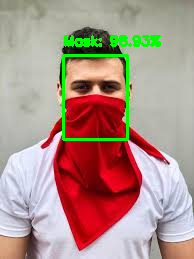

-1

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)